# NetBeez API examples
## Example 1: Retrive PING test results from a specific agent for the past 60 minutes
## Example 2: Display top 10 agents with most alerts from the last 24 hours

This notebook uses a Python environment to demonstrate how a NetBeez user can retrive data from the API and manipulate them and visualize them in a meaningful way.

First we describe the setup process for getting data from the API.

## Setup your NetBeez Beezkeeper details

First you need to identify your server's FQDN and generate an API key to use in these examples.

If the URL you use to access NetBeez looks like this https://demo.netbeecloud.net then `demo.netbeecloud.net` is the fqdn.

In [1]:
beezkeeper_fqdn="demo.netbeezcloud.net"  ## <--------- CHANGE THIS TO YOUR INSTANCE FQDN
base_url='https://' + beezkeeper_fqdn

In [2]:
from IPython.display import Markdown as md

md(f"To generate an API key head over to https://{beezkeeper_fqdn}/#settings-tab/api-keys-settings")

md(f"For documentation go to https://api.netbeez.net or https://{beezkeeper_fqdn}/swagger/")

For documentation go to https://api.netbeez.net or https://demo.netbeezcloud.net/swagger/

In [3]:
api_key="7g5_hKXw_460SNKEkJEYlMn1eqw3iTmaus_cCMZ8REhc5MOEtEAx8g"  # <--------- CHANGE THIS TO YOUR KEY

## Setup the headers
We define the content type format as JSON and provide the API key that you generated in the previous step as part of the headers.

In [4]:
import requests
import urllib3

urllib3.disable_warnings()


headers = {
            'Cache-Control': 'no-store',
            'Content-type': 'application/json',
            'Authorization': 'Bearer ' + api_key
          }

legacy_api_headers = {
    'Authorization': api_key,
    'API-VERSION': 'v1',
    'Content-type': 'application/json'
}

Note that when the legacy api headers are used it means that we are using the legacy API which is subject to be replaced soon by the new JSON API (documentation here: https://api.netbeez.net)

# Example 1: Get NetBeez Agent information and last 24 hours Ping results.

In this example we will be searching for an agent by name, then selecting the ping tests that are currently running, and then retriving the raw measurement results for those tests from the past 60 minutes.

## Retrieve the agent
First we set retrieve the agent by search by name using this API endpoint: https://api.netbeez.net/#f3d48709-5344-45b7-af9b-7b92feddd4ec.

In [5]:
search_name = "Virtual Agent"
url = f"{base_url}/agents?filter[name]={search_name}&type=beta"


In [6]:
response = requests.request("GET", url, headers=headers, verify=False)

import json
data = json.loads(response.text)
agent = data['data'][0]
print(agent)

{'id': '341', 'type': 'agent', 'attributes': {'name': 'Pittsburgh - Virtual Agent', 'reached_target_test_limit': False, 'reached_scheduled_test_limit': False, 'nb_target_ids': [463, 464, 465, 437, 32], 'nb_test_ids': [1667068, 1667069, 1667070, 1667065, 1667066, 1667067, 1667071, 1688201, 1688302, 1688303, 1688304, 1688305, 1688306, 1688391, 1688392, 1688393, 1688394, 1688395, 1688474, 1688475, 1688476, 1688477, 1688478], 'agent_type_name': 'virtual-model-ova', 'os_version': 'Debian GNU/Linux 8.11 (jessie)', 'kernel_version': '#1 SMP Debian 3.16.51-3 (2017-12-13)', 'created_at': '2021-04-01T19:39:11.000Z', 'uuid': '00:0c:29:09:fa:ee', 'agent_class': 'virtual', 'active': True, 'active_ts': 1631648799161, 'description': None, 'category': 'network_agent', 'software_version': '8.1.1', 'open_incident_id': None, 'test_aggregate_counts_by_type': {'1': {'success': 4, 'fail': 0, 'warning': 1, 'paused': 0, 'unknown': 0}, '2': {'success': 5, 'fail': 0, 'warning': 0, 'paused': 0, 'unknown': 0}, '3

## Retrieve Ping tests
Then we iterate through the tests and select the ping tests.

In [7]:
nb_tests = []
for nb_test_id in agent['attributes']['nb_test_ids']:
    url = f"{base_url}/nb_tests/{nb_test_id}.json"
    response = requests.request("GET", url, headers=legacy_api_headers, verify=False)
    data = json.loads(response.text)
    if data['heir_type'] == 'PingTest':
        print(data)
        nb_tests.append(data)


{'id': 1667068, 'target': 'www.google.com', 'count': 0, 'interval': 5, 'timeout': 5, 'start_ts': '2021-04-01T15:39:11.736-04:00', 'created_at': '2021-04-01T19:39:11.000Z', 'updated_at': '2021-09-14T21:50:03.000Z', 'agent_id': 341, 'test_type_id': 1, 'heir_id': 11374, 'heir_type': 'PingTest', 'ad_hoc': False, 'test_name': None, 'nb_test_templatable_type': 'NbTestTemplate', 'nb_test_templatable_id': 99, 'current_alert_mode': 'success', 'wifi_profile_id': None, 'network_interface_id': 387, 'nb_target_id': 32, 'nb_test_template_id': 99, 'schedule_type': 'periodic', 'options': {'data_size': 54, 'dont_fragment': False, 'tos': None, 'port': None, 'ping_type': 2, 'flags': None, 'jitter_mos': True}, 'alert_mode': 'success', 'interface_type': 'wired'}
{'id': 1667065, 'target': 'demo-app.netbeezcloud.net', 'count': 0, 'interval': 5, 'timeout': 5, 'start_ts': '2021-04-01T15:39:11.604-04:00', 'created_at': '2021-04-01T19:39:11.000Z', 'updated_at': '2021-09-14T21:50:04.000Z', 'agent_id': 341, 'test_

## Retrive the results
Then we retrieve the results for the past 60 minutes.

In [8]:
import time
import datetime
to_ts = int(time.time() * 1000)
from_ts = to_ts - (60 * 60 * 1000)

print(datetime.datetime.fromtimestamp(from_ts/1000.0))
print(datetime.datetime.fromtimestamp(to_ts/1000.0))


2021-09-15 02:36:11.471000
2021-09-15 03:36:11.471000


In [9]:
results = []
import pandas as pd
for nb_test in nb_tests:
    url = f"{base_url}/results.json?nb_test_id={nb_test['id']}&from={from_ts}&to={to_ts}"
    response = requests.request("GET", url, headers=legacy_api_headers, verify=False)
    df = pd.json_normalize(json.loads(response.text), 'index')
    if df.empty == False :
        df['timestamp'] = df['timestamp'].transform(lambda x: datetime.datetime.fromtimestamp(x/1000.0))
        df.set_index('id', inplace=True)
        results.append(df)
    
results = pd.concat(results)

...and here is a printout of the results:

In [10]:
print(results)

             value               timestamp  sequence_number  nb_test_id
id                                                                     
10085450741   33.8 2021-09-15 02:36:16.237          2136751     1667068
10085450875   11.0 2021-09-15 02:36:21.240          2136752     1667068
10085451112   50.1 2021-09-15 02:36:26.244          2136753     1667068
10085451247   20.9 2021-09-15 02:36:31.254          2136754     1667068
10085451601   11.0 2021-09-15 02:36:36.254          2136755     1667068
...            ...                     ...              ...         ...
10085581720   10.6 2021-09-15 03:35:50.789          1337630     1688474
10085581912   12.1 2021-09-15 03:35:55.791          1337631     1688474
10085582096   10.6 2021-09-15 03:36:00.793          1337632     1688474
10085582332   16.4 2021-09-15 03:36:05.794          1337633     1688474
10085582487   11.6 2021-09-15 03:36:10.800          1337634     1688474

[3586 rows x 4 columns]


In [11]:
results_pivot = results.pivot(index='timestamp', columns='nb_test_id', values='value')
pf = results_pivot.interpolate()
print(pf)

nb_test_id               1667065  1667068  1688303  1688391  1688474
timestamp                                                           
2021-09-15 02:36:11.481      NaN      NaN    202.0      NaN      NaN
2021-09-15 02:36:16.217      NaN      NaN    202.0      NaN    34.50
2021-09-15 02:36:16.237      NaN     33.8    202.0  122.000    28.55
2021-09-15 02:36:16.461   10.500     28.1    202.0  116.375    22.60
2021-09-15 02:36:16.482   10.475     22.4    202.0  110.750    16.65
...                          ...      ...      ...      ...      ...
2021-09-15 03:36:10.746   10.400     13.6    199.4  103.760    13.52
2021-09-15 03:36:10.776   10.400     13.5    199.6  102.520    12.56
2021-09-15 03:36:10.800   10.400     13.5    199.8  101.280    11.60
2021-09-15 03:36:11.145   10.400     13.5    200.0  100.040    11.60
2021-09-15 03:36:11.155   10.400     13.5    200.0   98.800    11.60

[2963 rows x 5 columns]


<AxesSubplot:xlabel='timestamp'>

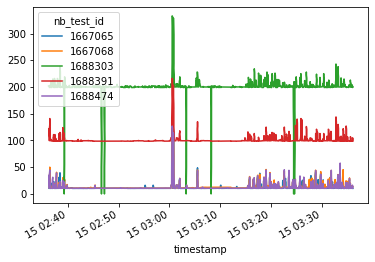

In [12]:
pf.plot()

# Example 2: Get the top 10 Agents with the most alerts triggered during the past 24 hours.

In this example we will be retrieve all the alerts triggered during the past 24 hours. Then we'll group them by agent and count them on a per agent basis. We then sort and pick the top 10. We then enrich the data with the agent names by fetching them through some extra API calls.

First we set the timestamps for `from` and `to`

In [13]:
import time
import datetime
to_ts = int(time.time() * 1000 - 3 * 24 * 60 * 60 * 1000)
from_ts = to_ts - (24 * 60 * 60 * 1000)

print(f"From: {datetime.datetime.fromtimestamp(from_ts/1000.0)}")
print(f"To:   {datetime.datetime.fromtimestamp(to_ts/1000.0)}")

From: 2021-09-11 03:36:25.776000
To:   2021-09-12 03:36:25.776000


We then retrieve the alerts using the `/nb_alerts.json` legacy api from swagger.

In [14]:
url = f"{base_url}/nb_alerts.json?from={from_ts}&to={to_ts}"
response = requests.request("GET", url, headers=legacy_api_headers, verify=False)

df = pd.json_normalize(response.json(), 'current_alerts')
print(df)

          id                                            message  severity  \
0    2171621  Agent connected to Access point: SSID: netbeez...         6   
1    2171620  Agent disconnected from Access point: SSID: Th...         1   
2    2171619                                      Alert cleared         6   
3    2171618                                           Time out         1   
4    2171617                 Send failure: Connection was reset         1   
..       ...                                                ...       ...   
439  2171182                                      Alert cleared         6   
440  2171181                                      Alert cleared         6   
441  2171180  Operation timed out after 5000 milliseconds wi...         1   
442  2171179  schannel: failed to receive handshake, SSL/TLS...         1   
443  2171178  schannel: failed to receive handshake, SSL/TLS...         1   

          alert_ts     state  alert_detector_instance_id  \
0    1631417504

Then we filter out only the alerts with severity less than 5 (faillure alerts have severity 1, and warning alerts have severity 4. When an alert is cleared that event is marked with severity 6). Then count the alerts per agent, and then get the top 10.

In [15]:
opening_alerts = df[df['severity'] < 5]
count_per_agent = opening_alerts[['source_agent_id', 'severity']].groupby(['source_agent_id']).count()
count_per_agent = count_per_agent.rename(columns={'severity':'count'})
count_per_agent.index = pd.to_numeric(count_per_agent.index, downcast='integer')
top_10 = count_per_agent.nlargest(10, columns='count')
print(top_10)

                 count
source_agent_id       
334                 90
325                 33
328                 25
270                 18
54                  14
300                 11
249                  8
319                  7
280                  5
297                  4


### Enrich the data with speedtest results:

In [16]:
search_term='Internet Bandwidth'
url = f"{base_url}/scheduled_nb_test_templates?filter[label]={search_term}"

response = requests.request("GET", url, headers=legacy_api_headers, verify=False)
scheduled_test_templates=response.json()
print(scheduled_test_templates)

{'data': [{'id': '1', 'type': 'scheduled_nb_test_template', 'attributes': {'label': 'Internet Bandwidth', 'target': '', 'test_type_id': 7, 'cron_schedule': '0 * * * *', 'pause_other_tests': True, 'heir_type': 'SpeedtestTemplate', 'created_at': '2016-08-11T21:43:39.000Z', 'configuration': {'server': '', 'secure': True, 'mini_server': None, 'speedtest_type': 1}, 'warning_conditions': {'or': [{'<': [{'var': 'down'}, 10]}, {'<': [{'var': 'up'}, 10]}, {'>': [{'var': 'latency'}, 80]}]}, 'last_result': {'min_severity': 1, 'error_count': 3, 'warning_count': 1, 'ts': 1631674800000, 'avg_result_values': [{'key': 'latency', 'value': 35.08592370840219}, {'key': 'up', 'value': 45.53846157514132}, {'key': 'down', 'value': 147.9007654923659}]}}, 'relationships': {'agents': {'data': [{'id': '280', 'type': 'agent'}, {'id': '305', 'type': 'agent'}, {'id': '226', 'type': 'agent'}, {'id': '54', 'type': 'agent'}, {'id': '341', 'type': 'agent'}, {'id': '325', 'type': 'agent'}, {'id': '334', 'type': 'agent'}

In [17]:
scheduled_nb_test_template_id = scheduled_test_templates['data'][0]['id']

agent_ids = ','.join(top_10.index.array.astype('str'))



In [18]:
url = f"{base_url}/scheduled_nb_test_templates/{scheduled_nb_test_template_id}/results?filter[ts][value1]={from_ts}&filter[ts][value1]={to_ts}&filter[ts][operator]<=>&filter[agent_ids]={agent_ids}"

response = requests.request("GET", url, headers=legacy_api_headers, verify=False)

print(response.json())

{'data': [{'id': '1330511', 'type': 'scheduled_nb_test_result', 'attributes': {'error_message': None, 'severity': 6, 'ts': 1623816000000, 'ssid': None, 'result_values': [{'key': 'down', 'value': 46.83}, {'key': 'latency', 'value': 6.294}, {'key': 'up', 'value': 71.72}], 'violated_condition': None}, 'relationships': {'agent': {'data': {'id': '280', 'type': 'agent'}}, 'nb_test': {'data': {'id': '1698646', 'type': 'nb_test'}}, 'scheduled_nb_test_template': {'data': {'id': '1', 'type': 'scheduled_nb_test_template'}}}}, {'id': '1330514', 'type': 'scheduled_nb_test_result', 'attributes': {'error_message': None, 'severity': 6, 'ts': 1623817500000, 'ssid': None, 'result_values': [{'key': 'down', 'value': 73.24}, {'key': 'latency', 'value': 6.012}, {'key': 'up', 'value': 92.53}], 'violated_condition': None}, 'relationships': {'agent': {'data': {'id': '280', 'type': 'agent'}}, 'nb_test': {'data': {'id': '1698653', 'type': 'nb_test'}}, 'scheduled_nb_test_template': {'data': {'id': '1', 'type': 's

In [19]:
results = pd.json_normalize(response.json()['data'])
print(results)


results = pd.json_normalize(results['attributes.result_values'])

print(results)

         id                      type attributes.error_message  \
0   1330511  scheduled_nb_test_result                     None   
1   1330514  scheduled_nb_test_result                     None   
2   1330516  scheduled_nb_test_result                     None   
3   1330518  scheduled_nb_test_result                     None   
4   1330521  scheduled_nb_test_result                     None   
5   1330523  scheduled_nb_test_result                     None   
6   1330525  scheduled_nb_test_result                     None   
7   1330528  scheduled_nb_test_result                     None   
8   1330530  scheduled_nb_test_result                     None   
9   1330532  scheduled_nb_test_result                     None   
10  1330535  scheduled_nb_test_result                     None   
11  1330537  scheduled_nb_test_result                     None   
12  1330539  scheduled_nb_test_result                     None   
13  1330542  scheduled_nb_test_result                     None   
14  133054

### Plot the alerts

To convert the agent ids to agent names we then retrieve the agent objects one by one and extract the name strings from those objects.

In [20]:
agent_names = []
for agent_id in top_10.index:
    url = f"{base_url}/agents/{agent_id}.json"
    response = requests.request("GET", url, headers=legacy_api_headers, verify=False)
    agent_names.append(response.json()['name'])
    
print("Done loading names")

Done loading names


Finally, we prepare the data for plotting.

In [21]:
to_plot = pd.DataFrame(index=agent_names, data=top_10.values, columns=['Alert Count'])
to_plot.index.rename('Agents')
print(to_plot)

                        Alert Count
Steven's - Desktop               90
Steven's - Laptop                33
JW8ZF2                           25
Container - AWS                  18
Cloud - Google                   14
San Jose - WiFi                  11
San Jose                          8
Pittsburgh - SmartSFP             7
Pittsburgh - Wired                5
Pittsburgh - WiFi Main            4


<AxesSubplot:>

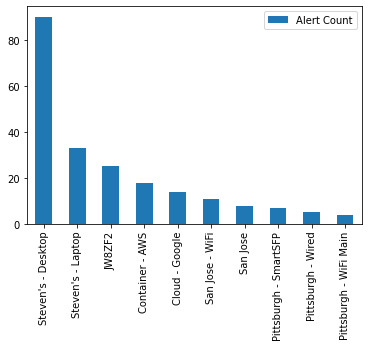

In [22]:
to_plot.plot.bar()